In [1]:
%pylab inline
from scipy.integrate import odeint 

Populating the interactive namespace from numpy and matplotlib


In [2]:
#set of equation of the model, computes dX/dt = f(X) where X is the vector of moles in each drop (water and CNs)
def vexch7(NN,t,K):
    f=[]
    P1,P2=K[0],K[1] #permeabilities of C1 and C2
    k12,k13,k4,PH2O,k22=K[2:7] #reaction rates of formose; !!!in the NMR code, Ntot is included in k, not here!!!
    Ninert,vH2O,vC1,vC2,vC3,vC4=K[7:13] #molar volume of the species

    NH2OA,N1A,N2A,N3A,N4A=NN[0],NN[1],NN[2],NN[3],NN[4] #list of moles in droplet A
    NH2OB,N1B,N2B,N3B,N4B=NN[5],NN[6],NN[7],NN[8],NN[9] #list of moles in droplet B
    
    NTA=NH2OA+N1A+N2A+N3A+N4A #total number of moles in droplet A
    NTB=NH2OB+N1B+N2B+N3B+N4B #total number of moles in droplet B
    
    VA=NH2OA*vH2O+N1A*vC1+N2A*vC2+N3A*vC3+N4A*vC4 #total volume of droplet A
    VB=NH2OB*vH2O+N1B*vC1+N2B*vC2+N3B*vC3+N4B*vC4 #total volume of droplet B
    
    PP=VA**(2.0/3.0)*VB**(2.0/3.0)/(VA**(2.0/3.0)+VB**(2.0/3.0)) #effective exchange area ()
   
    JH2OBA=PH2O*PP*(NH2OA/NTA-NH2OB/NTB)    #flux of water in mol/min
    JN1BA=P1*PP*(N1A/NTA-N1B/NTB)           #flux of C1
    JN2BA=P2*PP*(N2A/NTA-N2B/NTB)           #flux of C2
    
    #in droplet A
    f.append((-JH2OBA)) #H2OA
    f.append((-JN1BA  - k12*N1A*N2A/NTA - k13*N1A*N3A/NTA)) #variation of C1 due to fluxes and reactions
    f.append((-JN2BA - k12*N1A*N2A/NTA + 2.0*k4*N4A -2.0*k22*N2A**2/NTA)) #variation of C2
    f.append((-k13*N1A*N3A/NTA + k12*N1A*N2A/NTA)) #variation of C3
    f.append((+k13*N1A*N3A/NTA - k4*N4A + k22*N2A**2/NTA)) #variation of C4
    #in droplet B
    f.append((+JH2OBA)) #H2OB
    f.append((+JN1BA  - k12*N1B*N2B/NTB - k13*N1B*N3B/NTB))
    f.append((+JN2BA - k12*N1B*N2B/NTB + 2.0*k4*N4B -2.0*k22*N2B**2/NTB))
    f.append((-k13*N1B*N3B/NTB + k12*N1B*N2B/NTB))
    f.append((+k13*N1B*N3B/NTB - k4*N4B + k22*N2B**2/NTB))
 
    return f


In [3]:
#difference with ODEEXCHP5 is the possible initialization with non-zero amount of C3 and C4 and order of inputs
def ODEEXVFTransfer2(Va,Vb,P0,P1,P2,kk,krel,T,C1a,C2a,C3a,C4a,C1b,C2b,C3b,C4b):
    # ODE solver parameters
    TT=1
    abserr = 1.0e-10
    relerr = 1.0e-11
    stoptime = T*1.0
    numpoints = T*100
    # Create the time samples for the output of the ODE solver.
    t = [stoptime * float(i) / (numpoints - 1) for i in range(numpoints)]

    k12=kk*krel #*50 #C1+C2 aldol rate
    k13=kk*krel #*50 #C1+C3 aldol rate
    k4=kk #C4 cleavage by retro-aldol
    k22=kk*krel #C2+C2->C4 aldol
    
    PH2O=P0
    
    Ninert=0.00
    
    [vvH2O,vvC1,vvC2,vvC3,vvC4]=0.018,0.029,0.041,0.053,0.065 #modified by PN
    k=[P1,P2,k12,k13,k4,PH2O,k22,Ninert,vvH2O,vvC1,vvC2,vvC3,vvC4]
    
    NL0=zeros(10)
    #initialize droplet A
    NL0[0]=Va*(1.0-vvC1*C1a-vvC2*C2a-vvC3*C3a-vvC4*C4a)/vvH2O #VA 90
    NL0[1]=Va*C1a #VB 60
    NL0[2]=Va*C2a #N2A #3.0 * NL0[0] #N1A
    NL0[3]=Va*C3a #* NL0[0] #N3A
    NL0[4]=Va*C4a #N4A
    #initialize droplet B
    NL0[5]=Vb *(1.0-C1b*vvC1-C2b*vvC2-vvC3*C3b-vvC4*C4b)/vvH2O #NH2OB
    NL0[6]=Vb * C1b #N1B 3.0*NL0[1] #N1B
    NL0[7]=Vb * C2b #N2B
    NL0[8]=Vb * C3b #N3B
    NL0[9]=Vb * C4b #N4B


    # Call the ODE solver.
    NLF = odeint(vexch7, NL0, t, args=(k,),
              atol=abserr, rtol=relerr)

    
    VAF,VBF=[],[]
    NNA=[[],[],[],[],[]]
    NNB=[[],[],[],[],[]]
    for i in range(len(t)):
        VAF.append(NLF[int(i)][0]*vvH2O+NLF[int(i)][1]*vvC1+NLF[int(i)][2]*vvC2+NLF[int(i)][3]*vvC3+NLF[int(i)][4]*vvC4)
        VBF.append(NLF[int(i)][5]*vvH2O+NLF[int(i)][6]*vvC1+NLF[int(i)][7]*vvC2+NLF[int(i)][8]*vvC3+NLF[int(i)][9]*vvC4)
        for k in range(5):
            NNA[k].append(NLF[int(i)][k])
            NNB[k].append(NLF[int(i)][5+k])
        
    return VAF,VBF,NNA,NNB

In [4]:
#define parameters of the simulations
P0=200.0 #permeability of water for formose conditions at 20 um
kk=0.06
krel=55*47
P1=P0
P2=0.05*P0
VA,VB=40,80
T=260
Tx=T*10

In [5]:
C1a,C2a,C3a,C4a=1.0,0.2,0.0,0.0
C1b,C2b,C3b,C4b=1.0,0.0,0.0,0.0

VTAlist,VTBlist=[],[]
N1Alist,N1Blist=[],[]
N2Alist,N2Blist=[],[]
C1AL,C2AL=[],[]
C1BL,C2BL=[],[]

ntrans=10
for nnt in range(ntrans):
    [VAA,VBB,NNA,NNB]=ODEEXVFTransfer2(VA,VB,P0,P1,P2,kk,krel,T,C1a,C2a,C3a,C4a,C1b,C2b,C3b,C4b)
    VTAlist.extend(VAA[::100])
    VTBlist.extend(VBB[::100])
    
    N1Alist.extend(NNA[1][::100])
    N2Alist.extend(NNA[2][::100])
    N1Blist.extend(NNB[1][::100])
    N2Blist.extend(NNB[2][::100])
    
    C1AL.extend([NNA[1][::100][k]/VAA[::100][k] for k in range(len(VAA[::100]))])
    C2AL.extend([NNA[2][::100][k]/VAA[::100][k] for k in range(len(VAA[::100]))])
    C1BL.extend([NNB[1][::100][k]/VBB[::100][k] for k in range(len(VBB[::100]))])
    C2BL.extend([NNB[2][::100][k]/VBB[::100][k] for k in range(len(VBB[::100]))])

    VA=VTAlist[-1]/2 #droplet A is cut half
    [C1a,C2a,C3a,C4a]=[NNA[1+k][-1]/(2*VA) for k in range(4)]


In [6]:
VA,VB=40,80
C1a,C2a,C3a,C4a=1.0,0.001,0.0,0.0
C1b,C2b,C3b,C4b=1.0,0,0.0,0.0

VTAlist2,VTBlist2=[],[]
N1Alist2,N1Blist2=[],[]
N2Alist2,N2Blist2=[],[]
C1AL2,C2AL2=[],[]
C1BL2,C2BL2=[],[]

ntrans=10
for nnt in range(ntrans):
    [VAA,VBB,NNA,NNB]=ODEEXVFTransfer2(VA,VB,P0,P1,P2,kk,krel,T,C1a,C2a,C3a,C4a,C1b,C2b,C3b,C4b)
    VTAlist2.extend(VAA[::100])
    VTBlist2.extend(VBB[::100])
    
    N1Alist2.extend(NNA[1][::100])
    N2Alist2.extend(NNA[2][::100])
    N1Blist2.extend(NNB[1][::100])
    N2Blist2.extend(NNB[2][::100])
    
    C1AL2.extend([NNA[1][::100][k]/VAA[::100][k] for k in range(len(VAA[::100]))])
    C2AL2.extend([NNA[2][::100][k]/VAA[::100][k] for k in range(len(VAA[::100]))])
    C1BL2.extend([NNB[1][::100][k]/VBB[::100][k] for k in range(len(VBB[::100]))])
    C2BL2.extend([NNB[2][::100][k]/VBB[::100][k] for k in range(len(VBB[::100]))])

    VA=VTAlist2[-1]/2 #droplet A is cut half
    [C1a,C2a,C3a,C4a]=[NNA[1+k][-1]/(2*VA) for k in range(4)]


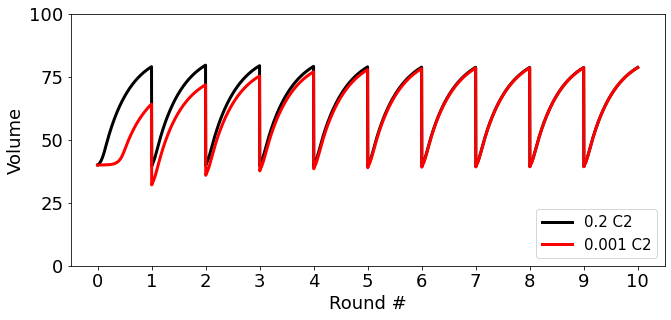

In [7]:
matplotlib.pyplot.subplots_adjust(left=None, bottom=None, right=1.5, top=1.0, wspace=0.3, hspace=0.5)
plt.plot(np.linspace(0,ntrans,len(VTAlist)),VTAlist,'k', linewidth=3.0, label='0.2 C2')
plt.plot(np.linspace(0,ntrans,len(VTAlist2)),VTAlist2,'r', linewidth=3.0, label='0.001 C2')
#plt.plot(np.linspace(0,ntrans,len(VTBlist)),VTBlist,'r',alpha=0.3, linewidth=3.0, label='2')
#plt.plot(VTBlist,label='2')

xticks([0,1,2,3,4,5,6,7,8,9,10],size=18)
yticks([0,25,50,75,100],size=18)
xlabel('Round #', size=18)
ylabel('Volume', size=18)
legend(loc=4,fontsize=15)
#plt.savefig('serialTransferVolume.eps',bbox_inches='tight')

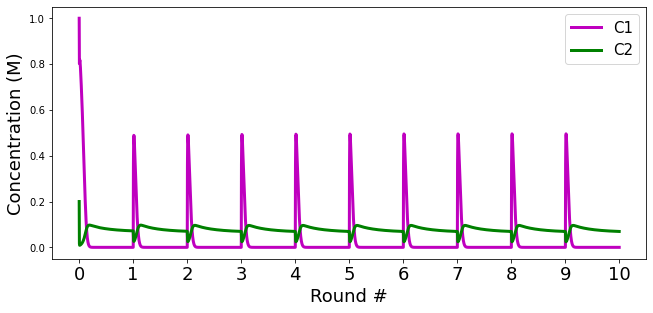

In [8]:
matplotlib.pyplot.subplots_adjust(left=None, bottom=None, right=1.5, top=1.0, wspace=0.3, hspace=0.5)
plt.plot(np.linspace(0,ntrans,len(C1AL)),C1AL,'m', linewidth=3.0, label='C1')
plt.plot(np.linspace(0,ntrans,len(C2AL)),C2AL,'g', linewidth=3.0, label='C2')

xticks([0,1,2,3,4,5,6,7,8,9,10],size=18)
xlabel('Round #', size=18)
ylabel('Concentration (M)', size=18)
legend(loc=1,fontsize=15)
#plt.savefig('SerialTransferC1C2rounds.eps',bbox_inches='tight')

Text(0, 0.5, '$[C_2] (M)$')

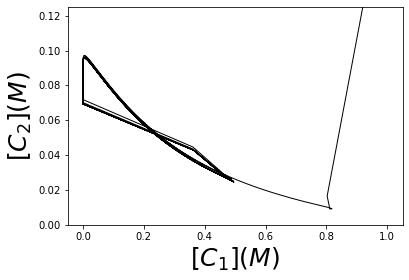

In [9]:
plot(C1AL,C2AL, 'k', linewidth=1, label='1' )

ylim(0,0.125)
#xlim(0.,0.6)
xlabel(r'$[C_1] (M)$', size=25)
ylabel(r'$[C_2] (M)$', size=25)
#savefig('SerialTransferC1versusC2.eps',dpi=1000,transparent='False',bbox_inches='tight')